## Imports

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import linregress
import numpy as np
import os
import math
import collections

## Load Data

In [3]:
class Observation:
    def __init__(self, mag_field_volt, mag_field_curr, filter, sample, min_trans_eye,
                angles, intensities):
        self.mag_field_volt = mag_field_volt
        self.mag_field_curr = mag_field_curr
        self.filter = filter
        self.sample = sample
        self.min_trans_eye = min_trans_eye
        self.angles = angles
        self.intensities = intensities

In [4]:
data_file = 'data/faraday_data.xlsx'

In [5]:
full_df = pd.read_excel(data_file)
full_df

Magnetic Field voltage (V)  Magnetic Field Current (Amps) Filter  \
0                            0                           0.00    Red   
1                            0                           0.00    Red   
2                            0                           0.00    Red   
3                            0                           0.00   Blue   
4                            0                           0.00   Blue   
..                         ...                            ...    ...   
58                         -30                          -1.22   Blue   
59                         -30                          -1.22   Blue   
60                         -30                          -1.22    Red   
61                         -30                          -1.22    Red   
62                         -30                          -1.22    Red   

    Sample (cm)  Min transmission angle  Unnamed: 5  Angle 1  Value 1  \
0         1.036                     334         NaN      294   0.0315   
1         0.956                     332         NaN      292   0.0426   
2         1.272                     339         NaN      299   0.0223   
3         1.272                     332         NaN      292   0.0526   
4         0.956                     340         NaN      300   0.0548   
..          ...                     ...         ...      ...      ...   
58        1.272                     346         NaN      306   0.0210   
59        1.036                     313         NaN      273   0.0532   
60        0.956                     341         NaN      301   0.0230   
61        1.272                     340         NaN      300   0.0249   
62        1.036                     328         NaN      288   0.0165   

    Angle 2  Value 2  ...  Angle 5   Value 5  Angle 6  Value 6  Angle 7  \
0       304   0.0205  ...      334  0.000500      344  0.00250      354   
1       302   0.0271  ...      332  0.002170      342  0.00275      352   
2       309   0.0134  ...      339  0.001230      349  0.00447      359   
3       302   0.0378  ...      332  0.000521      342  0.00696      352   
4       310   0.0359  ...      340  0.007140      350  0.01620      360   
..      ...      ...  ...      ...       ...      ...      ...      ...   
58      316   0.0139  ...      346  0.001360      356  0.00360      366   
59      283   0.0379  ...      313  0.001880      323  0.00499      333   
60      311   0.0133  ...      341  0.002380      351  0.00615      361   
61      310   0.0156  ...      340  0.000984      350  0.00202      360   
62      298   0.0101  ...      328  0.000613      338  0.00209      348   

    Value 7  Angle 8  Value 8  Angle 9  Value 9  
0   0.00760      364   0.0170      374   0.0300  
1   0.00672      362   0.0137      372   0.0214  
2   0.01080      369   0.0186      379   0.0275  
3   0.01580      362   0.0300      372   0.0457  
4   0.03240      370   0.0508      380   0.0646  
..      ...      ...      ...      ...      ...  
58  0.00878      376   0.0157      386   0.0234  
59  0.01600      343   0.0310      353   0.0468  
60  0.01290      371   0.0222      381   0.0313  
61  0.00608      370   0.0118      380   0.0194  
62  0.00577      358   0.0111      368   0.0175  

[63 rows x 24 columns]

In [6]:
observation_arr = []
for i, row in full_df.iterrows():
    mag_field_volt, mag_field_curr, filter, sample, min_trans_eye = row[0:5].values
    angles = [row[f"Angle {j}"] for j in range(1, 10)]
    intensities = [row[f"Value {j}"] for j in range(1, 10)]
    observation = Observation(mag_field_volt, 
                              mag_field_curr, 
                              filter, 
                              sample, 
                              min_trans_eye, 
                              angles, 
                              intensities)
    observation_arr.append(observation)

## Malus Fit Class

In [7]:
class MalusFit:
    def __init__(self, observation):
        self.observation = observation
        self.angles = observation.angles
        self.intensities = observation.intensities
        self.fit()
        
    def fit(self):
        """
        Fit malus curve to angles and intensities
        """
        m1_guess = np.max(intensities)
        m2_guess = np.max(intensities)
        m3_guess = angles[np.argmin(intensities)]
        params, covariance = curve_fit(self.malus_curve, 
                                           self.angles, 
                                           self.intensities, 
                                           p0=[m1_guess, m2_guess, m3_guess])
        self.m1, self.m2, self.m3 = params
        
    def malus_curve(self, x, m1, m2, m3):
        return m1 - m2 * (np.cos(np.deg2rad(x - m3))) ** 2

    def get_min_angle(self):
        """
        Find the minimum transmission angle based on fit parameters
        """
        return self.m3

    def plot_fit(self, ax):
        """
        Plot malus fit to intensities, with both data and fitted curve
        """
        fit_angles = np.linspace(np.min(self.angles), 
                                 np.max(self.angles), 
                                 100)
        fitted_intensities = self.malus_curve(fit_angles, 
                                              self.m1, 
                                              self.m2, 
                                              self.m3)
        ax.plot(fit_angles, fitted_intensities, color = "red")
        ax.scatter(self.angles, self.intensities)
        ax.set_title(f"{self.observation.mag_field_volt} V," 
                     f"{self.observation.filter},"
                     f"{self.observation.sample}")

## Create 0 magnetic field fits

In [8]:
import collections
zero_field_angles = collections.defaultdict(dict)

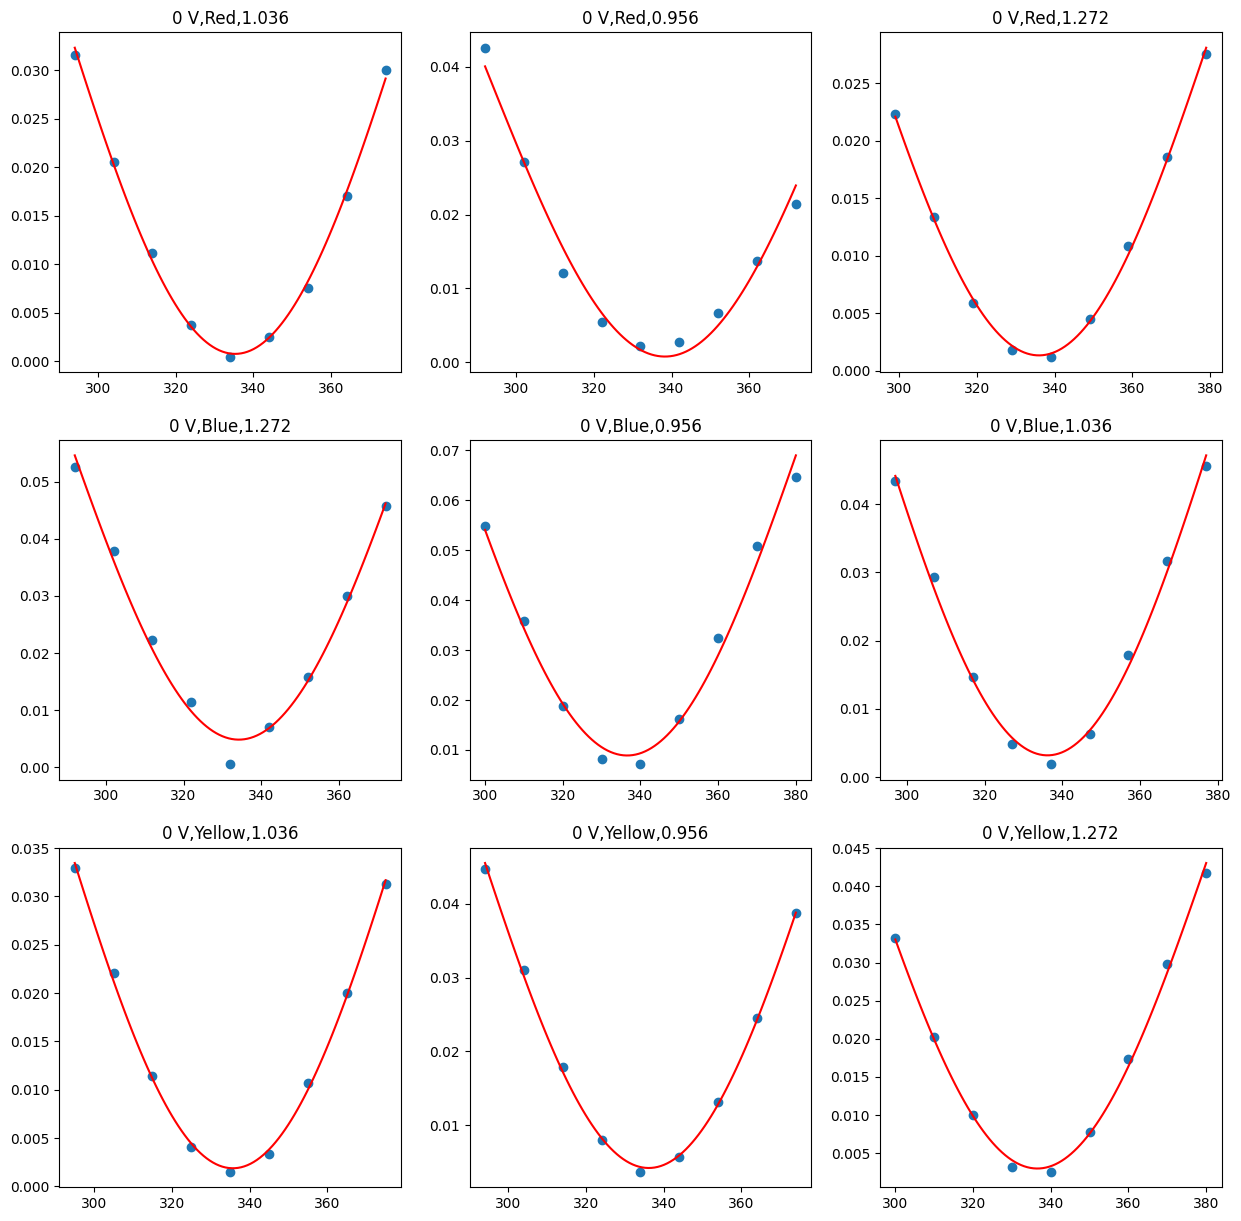

In [9]:
## Fit the 9 0 field datapoints
fig, axes = plt.subplots(3, 3, figsize = (15, 15))
for i, ax in enumerate(axes.flatten()):
    observation = observation_arr[i]
    mf = MalusFit(observation)
    mf.plot_fit(ax)
    zero_field_angles[observation.filter][observation.sample] = mf.get_min_angle()

In [10]:
zero_field_angles

defaultdict(dict,
            {'Red': {1.036: 335.2749258914456,
              0.956: 338.2878403828215,
              1.272: 335.9579153280217},
             'Blue': {1.272: 334.2244603817874,
              0.956: 336.576889640291,
              1.036: 336.14800698539506},
             'Yellow': {1.036: 335.6961290684387,
              0.956: 336.13170163781405,
              1.272: 336.54722588930997}})

In [11]:
full_df["zero_field_angle"] = 0

In [12]:
full_df

Magnetic Field voltage (V)  Magnetic Field Current (Amps) Filter  \
0                            0                           0.00    Red   
1                            0                           0.00    Red   
2                            0                           0.00    Red   
3                            0                           0.00   Blue   
4                            0                           0.00   Blue   
..                         ...                            ...    ...   
58                         -30                          -1.22   Blue   
59                         -30                          -1.22   Blue   
60                         -30                          -1.22    Red   
61                         -30                          -1.22    Red   
62                         -30                          -1.22    Red   

    Sample (cm)  Min transmission angle  Unnamed: 5  Angle 1  Value 1  \
0         1.036                     334         NaN      294   0.0315   
1         0.956                     332         NaN      292   0.0426   
2         1.272                     339         NaN      299   0.0223   
3         1.272                     332         NaN      292   0.0526   
4         0.956                     340         NaN      300   0.0548   
..          ...                     ...         ...      ...      ...   
58        1.272                     346         NaN      306   0.0210   
59        1.036                     313         NaN      273   0.0532   
60        0.956                     341         NaN      301   0.0230   
61        1.272                     340         NaN      300   0.0249   
62        1.036                     328         NaN      288   0.0165   

    Angle 2  Value 2  ...   Value 5  Angle 6  Value 6  Angle 7  Value 7  \
0       304   0.0205  ...  0.000500      344  0.00250      354  0.00760   
1       302   0.0271  ...  0.002170      342  0.00275      352  0.00672   
2       309   0.0134  ...  0.001230      349  0.00447      359  0.01080   
3       302   0.0378  ...  0.000521      342  0.00696      352  0.01580   
4       310   0.0359  ...  0.007140      350  0.01620      360  0.03240   
..      ...      ...  ...       ...      ...      ...      ...      ...   
58      316   0.0139  ...  0.001360      356  0.00360      366  0.00878   
59      283   0.0379  ...  0.001880      323  0.00499      333  0.01600   
60      311   0.0133  ...  0.002380      351  0.00615      361  0.01290   
61      310   0.0156  ...  0.000984      350  0.00202      360  0.00608   
62      298   0.0101  ...  0.000613      338  0.00209      348  0.00577   

    Angle 8  Value 8  Angle 9  Value 9  zero_field_angle  
0       364   0.0170      374   0.0300                 0  
1       362   0.0137      372   0.0214                 0  
2       369   0.0186      379   0.0275                 0  
3       362   0.0300      372   0.0457                 0  
4       370   0.0508      380   0.0646                 0  
..      ...      ...      ...      ...               ...  
58      376   0.0157      386   0.0234                 0  
59      343   0.0310      353   0.0468                 0  
60      371   0.0222      381   0.0313                 0  
61      370   0.0118      380   0.0194                 0  
62      358   0.0111      368   0.0175                 0  

[63 rows x 25 columns]

In [13]:
for i, row in full_df.iterrows():
    filter = row['Filter']
    sample = row['Sample (cm)']
    full_df.at[i, "zero_field_angle"] = zero_field_angles[filter][sample]

C:\Users\Jackson\AppData\Local\Temp\ipykernel_2820\3181251812.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '335.2749258914456' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  full_df.at[i, "zero_field_angle"] = zero_field_angles[filter][sample]


In [14]:
full_df

Magnetic Field voltage (V)  Magnetic Field Current (Amps) Filter  \
0                            0                           0.00    Red   
1                            0                           0.00    Red   
2                            0                           0.00    Red   
3                            0                           0.00   Blue   
4                            0                           0.00   Blue   
..                         ...                            ...    ...   
58                         -30                          -1.22   Blue   
59                         -30                          -1.22   Blue   
60                         -30                          -1.22    Red   
61                         -30                          -1.22    Red   
62                         -30                          -1.22    Red   

    Sample (cm)  Min transmission angle  Unnamed: 5  Angle 1  Value 1  \
0         1.036                     334         NaN      294   0.0315   
1         0.956                     332         NaN      292   0.0426   
2         1.272                     339         NaN      299   0.0223   
3         1.272                     332         NaN      292   0.0526   
4         0.956                     340         NaN      300   0.0548   
..          ...                     ...         ...      ...      ...   
58        1.272                     346         NaN      306   0.0210   
59        1.036                     313         NaN      273   0.0532   
60        0.956                     341         NaN      301   0.0230   
61        1.272                     340         NaN      300   0.0249   
62        1.036                     328         NaN      288   0.0165   

    Angle 2  Value 2  ...   Value 5  Angle 6  Value 6  Angle 7  Value 7  \
0       304   0.0205  ...  0.000500      344  0.00250      354  0.00760   
1       302   0.0271  ...  0.002170      342  0.00275      352  0.00672   
2       309   0.0134  ...  0.001230      349  0.00447      359  0.01080   
3       302   0.0378  ...  0.000521      342  0.00696      352  0.01580   
4       310   0.0359  ...  0.007140      350  0.01620      360  0.03240   
..      ...      ...  ...       ...      ...      ...      ...      ...   
58      316   0.0139  ...  0.001360      356  0.00360      366  0.00878   
59      283   0.0379  ...  0.001880      323  0.00499      333  0.01600   
60      311   0.0133  ...  0.002380      351  0.00615      361  0.01290   
61      310   0.0156  ...  0.000984      350  0.00202      360  0.00608   
62      298   0.0101  ...  0.000613      338  0.00209      348  0.00577   

    Angle 8  Value 8  Angle 9  Value 9  zero_field_angle  
0       364   0.0170      374   0.0300        335.274926  
1       362   0.0137      372   0.0214        338.287840  
2       369   0.0186      379   0.0275        335.957915  
3       362   0.0300      372   0.0457        334.224460  
4       370   0.0508      380   0.0646        336.576890  
..      ...      ...      ...      ...               ...  
58      376   0.0157      386   0.0234        334.224460  
59      343   0.0310      353   0.0468        336.148007  
60      371   0.0222      381   0.0313        338.287840  
61      370   0.0118      380   0.0194        335.957915  
62      358   0.0111      368   0.0175        335.274926  

[63 rows x 25 columns]

In [15]:
full_df.to_excel("data/temp_data.xlsx")